In [1]:
# -*- coding: utf-8 -*-

In [2]:
## package import

In [3]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d

In [4]:
## util 함수들 구현

In [5]:
# numerical gradient 계산 util
def numerical_gradient(f, point, step_size=1e-5):
    # 도함수를 직접 구하지 않고 미분값을 구하려는 point 주변의 값을 사용하여 수치적으로 근사함

    # input vector 차원
    dim = len(point)

    # 구할 gradient 변수 초기화
    gradient = np.zeros(dim)

    for i in range(dim):

        # 미분값을 구하려는 point 근방의 점을 지정
        positive_perturb = np.array(point, dtype='Float64')
        negative_perturb = np.array(point, dtype='Float64')

        positive_perturb[i] += step_size
        negative_perturb[i] -= step_size

        # 수치적으로 근사한 값에 noise 를 주어서 gradient 가 완전히 0으로 묶이는 상황을 방지
        noise = np.abs(np.random.randn(1)) * step_size**2

        # coordinate 별로 gradient 의 근사값 계산
        gradient[i] = (f(positive_perturb) - f(negative_perturb)) / (2 * step_size) + noise
    return gradient

In [6]:
# 경로 저장 관련 util
def initialize_trajectory(starting_point):
    # initial point 를 받아서 경로 저장에 사용할 list 변수 리턴 (2변수 함수임을 전제함)

    x_trajectory = [starting_point[0]]
    y_trajectory = [starting_point[1]]
    return x_trajectory, y_trajectory


def append_trajectory(x_update, y_update, new_point):
    # 새로 업데이트된 point 를 받아서 경로를 저장하는 list 에 append (2변수 함수임을 전제함)

    x_update.append(new_point[0])
    y_update.append(new_point[1])
    return x_update, y_update

In [7]:
# mesh 시각화 util
def mesh_generation():
    # [-1, 1]^3 범위에 해당하는 3D 공간를 시각화하기 위해 mesh size = 0.005 의 mesh 생성

    lower_bound = -1
    upper_bound = 1
    resolution = 401
    x_lin = np.linspace(lower_bound, upper_bound, resolution)
    y_lin = np.linspace(lower_bound, upper_bound, resolution)
    x_mesh, y_mesh = np.meshgrid(x_lin, y_lin)
    return x_mesh, y_mesh

In [8]:
## optimizer 구현

In [9]:
# Gradient Descent Method
def gradient_descent_update(loss_ftn, point):
    
    # 입력 변수의 데이터 타입 변환
    point = np.array(point, dtype='Float64')

    # learning rate 설정
    eta = 0.1

    # gradient 측정 > point 업데이트
    gradient = numerical_gradient(loss_ftn, point)
    point_update = point - eta * gradient

    return point_update

In [10]:
# Momentum Method
def momentum_update(loss_ftn, point, previous_update):
    
    # 입력 변수의 데이터 타입 변환
    point = np.array(point, dtype='Float64')
    previous_update = np.array(previous_update, dtype='Float64')

    # learning rate, 가중평균 weight 설정
    eta = 0.1
    gamma = 0.9

    # gradient 측정 > 업데이트 term 계산 > point 업데이트
    gradient = numerical_gradient(loss_ftn, point)
    current_update = gamma * previous_update + eta * gradient
    point_update = point - current_update

    return point_update, current_update

In [11]:
# NAG Method
def nag_update(loss_ftn, point, previous_update):
    
    # 입력 변수의 데이터 타입 변환
    point = np.array(point, dtype='Float64')
    previous_update = np.array(previous_update, dtype='Float64')

    # learning rate, 가중 평균 weight 설정
    eta = 0.1
    gamma = 0.9

    # gradient 측정 point 예측 > 해당 지점에서 gradient 계산 > 업데이트 term 계산 > point 업데이트
    point_estimation = point - gamma * previous_update
    gradient = numerical_gradient(loss_ftn, point_estimation)
    current_update = gamma * previous_update + eta * gradient
    point_update = point - current_update

    return point_update, current_update

In [12]:
# AdaGrad Method
def adagrad_update(loss_ftn, point, previous_gradient2):
    
    # 입력 변수의 데이터 타입 변환
    point = np.array(point, dtype='Float64')
    previous_gradient2 = np.array(previous_gradient2, dtype='Float64')

    # learning rate, epsilon 설정
    eta = 0.1
    epsilon = 1e-8

    # gradient 측정 > Hessian 추정 > point 업데이트
    gradient = numerical_gradient(loss_ftn, point)
    current_gradient2 = previous_gradient2 + gradient**2
    point_update = point - eta * gradient / np.sqrt(current_gradient2 + epsilon)

    return point_update, current_gradient2

In [13]:
# AdaDelta Method
def adadelta_update(loss_ftn, point, previous_avg_gradient2, previous_avg_delta_x2):
    
    # 입력 변수의 데이터 타입 변환
    point = np.array(point, dtype='Float64')
    previous_avg_gradient2 = np.array(previous_avg_gradient2, dtype='Float64')
    previous_avg_delta_x2 = np.array(previous_avg_delta_x2, dtype='Float64')

    # 가중 평균 weight, epsilon 설정
    ro = 0.9
    epsilon = 1e-4

    # gradient 측정
    gradient = numerical_gradient(loss_ftn, point)

    # Hessian 추정값의 가중 평균 계산
    current_avg_gradient2 = ro * previous_avg_gradient2 + (1 - ro) * gradient**2

    # 업데이트 term & Hessian 추정값 가중 평균의 Rooted Mean Square 계산
    rms_delta_x = np.sqrt(previous_avg_delta_x2 + epsilon)
    rms_gradient = np.sqrt(current_avg_gradient2 + epsilon)
    delta_x = - rms_delta_x / rms_gradient * gradient

    # 업데이트 term 가중 평균 계산
    current_avg_delta_x2 = ro * previous_avg_delta_x2 + (1 - ro) * delta_x**2

    # point 업데이트
    point_update = point + delta_x

    return point_update, current_avg_gradient2, current_avg_delta_x2

In [14]:
# Adam Method
def adam_update(loss_ftn, point, step, previous_momentum, previous_variance):
    
    # 입력 변수의 데이터 타입 변환
    point = np.array(point, dtype='Float64')
    previous_momentum = np.array(previous_momentum, dtype='Float64')
    previous_variance = np.array(previous_variance, dtype='Float64')

    # learning rate, 가중 평균 weight, epsilon 설정
    eta = 0.1
    beta_m = 0.9
    beta_v = 0.9
    epsilon = 1e-8

    # gradient 측정 > gradient & Hessian 추정값의 가중 평균 계산
    gradient = numerical_gradient(loss_ftn, point)
    current_momentum = beta_m * previous_momentum + (1 - beta_m) * gradient
    current_variance = beta_v * previous_variance + (1 - beta_v) * gradient**2

    # 가중 평균 계산 결과의 bias correction
    current_momentum_bc = current_momentum / (1 - np.power(beta_m, step + 1))
    current_variance_bc = current_variance / (1 - np.power(beta_v, step + 1))

    # point 업데이트
    point_update = point - eta * current_momentum_bc / (np.sqrt(current_variance_bc) + epsilon)

    return point_update, current_momentum, current_variance

In [15]:
## loss function 정의 

In [16]:
# saddle point 존재하는 loss function 예시
def loss_function(x):
    l = x[0]**2 - x[1]**2
    return l

In [17]:
## 경로 변수 초기화

In [18]:
# initial point & initial gradient 설정
initial_point = [-1.0, 0.0]
initial_grad = [0, 0]

# gradient descent 경로 추적을 위한 변수 생성
x_gd, y_gd = initialize_trajectory(initial_point)

# momentum 경로 추적을 위한 변수 및 초기값 생성
x_mom, y_mom = initialize_trajectory(initial_point)
previous_update_mom = initial_grad

# nag 경로 추적을 위한 변수 및 초기값 생성
x_nag, y_nag = initialize_trajectory(initial_point)
previous_update_nag = initial_grad

# adagrad 경로 추적을 위한 변수 및 초기값 생성
x_adag, y_adag = initialize_trajectory(initial_point)
previous_grad2_adag = initial_grad

# adadelta 경로 추적을 위한 변수 및 초기값 생성
x_adad, y_adad = initialize_trajectory(initial_point)
previous_avg_delta_x2_adad = np.array(initial_grad)
previous_avg_grad2_adad = np.array(initial_grad)**2

# adam 경로 추적을 위한 변수 및 초기값 생성
x_adam, y_adam = initialize_trajectory(initial_point)
previous_momentum_adam = np.array(initial_grad)
previous_variance_adam = np.array(initial_grad)**2

In [19]:
## 최적화 수행

In [20]:
for i in range(60):
    
    # gradient descent 업데이트 > 경로 변수에 저장
    point_gd = gradient_descent_update(loss_function, [x_gd[i], y_gd[i]])
    x_gd, y_gd = append_trajectory(x_gd, y_gd, point_gd)

    # momentum 업데이트 > 경로 변수에 저장 > time step 업데이트
    point_mom, current_update_mom = momentum_update(loss_function, [x_mom[i], y_mom[i]], previous_update_mom)
    x_mom, y_mom = append_trajectory(x_mom, y_mom, point_mom)
    previous_update_mom = current_update_mom

    # nag 업데이트 > 경로 변수에 저장 > time step 업데이트
    point_nag, current_update_nag = nag_update(loss_function, [x_nag[i], y_nag[i]], previous_update_nag)
    x_nag, y_nag = append_trajectory(x_nag, y_nag, point_nag)
    previous_update_nag = current_update_nag

    # adagrad 업데이트 > 경로 변수에 저장 > time step 업데이트
    point_adag, current_grad2_adag = \
        adagrad_update(loss_function, [x_adag[i], y_adag[i]], previous_grad2_adag)
    x_adag, y_adag = append_trajectory(x_adag, y_adag, point_adag)
    previous_grad2_adag = current_grad2_adag

    # adadelta 업데이트 > 경로 변수에 저장 > time step 업데이트
    point_adad, current_avg_grad2_adad, current_avg_delta_x2_adad = \
        adadelta_update(loss_function, [x_adad[i], y_adad[i]], previous_avg_grad2_adad, previous_avg_delta_x2_adad)
    x_adad, y_adad = append_trajectory(x_adad, y_adad, point_adad)
    previous_avg_grad2_adad = current_avg_grad2_adad
    previous_avg_delta_x2_adad = current_avg_delta_x2_adad

    # adam 업데이트 > 경로 변수에 저장 > time step 업데이트
    point_adam, current_momentum_adam, current_variance_adam = \
        adam_update(loss_function, [x_adam[i], y_adam[i]], i, previous_momentum_adam, previous_variance_adam)
    x_adam, y_adam = append_trajectory(x_adam, y_adam, point_adam)
    previous_momentum_adam = current_momentum_adam
    previous_variance_adam = current_variance_adam

/home/ubuntu/tf_py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  """
/home/ubuntu/tf_py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
/home/ubuntu/tf_py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  from ipykernel import kernelapp as app
/home/ubuntu/tf_py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
/home/ubuntu/tf_py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  import sys


In [21]:
## 시각화

<IPython.core.display.Javascript object>


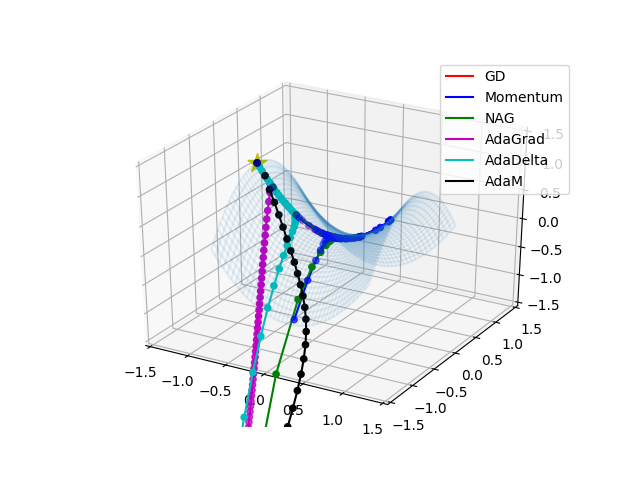

In [22]:
# 3D 공간 시각화를 위한 mesh 생성
X, Y = mesh_generation()
 
# loss function mesh 생성
Z = loss_function([X, Y])

# mesh 시각화
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10, alpha=0.1)

# 그래프 시점 고정
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)

# initial point 플로팅
ax.scatter(-1, 0, 1, c='y', marker='*', s=200)

# gradient descent 경로 플로팅
ax.plot(x_gd, y_gd, loss_function(np.array([x_gd, y_gd])), c='r', label='GD')
ax.scatter(x_gd, y_gd, loss_function(np.array([x_gd, y_gd])), c='r')

# momentum 경로 플로팅
ax.plot(x_mom, y_mom, loss_function(np.array([x_mom, y_mom])), c='b', label='Momentum')
ax.scatter(x_mom, y_mom, loss_function(np.array([x_mom, y_mom])), c='b')

# nag 경로 플로팅
ax.plot(x_nag, y_nag, loss_function(np.array([x_nag, y_nag])), c='g', label='NAG')
ax.scatter(x_nag, y_nag, loss_function([np.array(x_nag), np.array(y_nag)]), c='g')

# adagrad 경로 플로팅
ax.plot(x_adag, y_adag, loss_function(np.array([x_adag, y_adag])), c='m', label='AdaGrad')
ax.scatter(x_adag, y_adag, loss_function(np.array([x_adag, y_adag])), c='m')

# adadelta 경로 플로팅
ax.plot(x_adad, y_adad, loss_function(np.array([x_adad, y_adad])), c='c', label='AdaDelta')
ax.scatter(x_adad, y_adad, loss_function(np.array([x_adad, y_adad])), c='c')

# adam 경로 플로팅
ax.plot(x_adam, y_adam, loss_function(np.array([x_adam, y_adam])), c='k', label='AdaM')
ax.scatter(x_adam, y_adam, loss_function(np.array([x_adam, y_adam])), c='k')

# 범례 그리기
plt.legend()

plt.show()